In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.model_selection import train_test_split
import optuna
from sklearn.neural_network import MLPClassifier

pd.set_option('display.max_columns', 1000)

# Load your data
print("Loading data...")
train1 = pd.read_csv("../../../labs/benjamin.yakir/gila/genomic_data/train_test/set1/modkit/HG001_train", sep='\t')
train2 = pd.read_csv("../../../labs/benjamin.yakir/gila/genomic_data/train_test/set1/modkit/HG002_train", sep='\t')
test1 = pd.read_csv("../../../labs/benjamin.yakir/gila/genomic_data/train_test/set1/modkit/HG001_test", sep='\t')
test2 = pd.read_csv("../../../labs/benjamin.yakir/gila/genomic_data/train_test/set1/modkit/HG002_test", sep='\t')
cpg = pd.read_csv("../../../labs/benjamin.yakir/gila/genomic_data/reference_data/CpG_HG38/CpG_chr21.csv")
cpg.rename(columns={'V1': 'chr', 'V2': 'ref_pos', 'V3': 'CpG_site'}, inplace=True)

def clean(df):
    print("Cleaning data...")
    df = df.groupby(['read_id', 'forward_read_position', 'ref_position', 'chrom', 'mod_strand', 'ref_strand', 'ref_mod_strand',
                'fw_soft_clipped_start', 'fw_soft_clipped_end', 'read_length', 'base_qual']).agg({'mod_qual': 'max'}).reset_index()

    df['ref_position_adj'] = np.where(df['ref_mod_strand'] == '+', df['ref_position'] + 1, df['ref_position'])
    df = df.merge(cpg, left_on='ref_position_adj', right_on='ref_pos', how='left')
    df.drop(columns=['chr', 'ref_pos'], inplace=True)

    return(df)

# Clean train and test data
train1 = clean(train1)
train2 = clean(train2)
test1 = clean(test1)
test2 = clean(test2)

train1 = train1[["read_id", "CpG_site", "mod_qual"]]
train2 = train2[["read_id", "CpG_site", "mod_qual"]]
test1 = test1[["read_id", "CpG_site", "mod_qual"]]
test2 = test2[["read_id", "CpG_site", "mod_qual"]]

def calculate_avg_mod_qual(df):
    print("Calculating average mod_qual for CpG sites...")
    return df.groupby('CpG_site')['mod_qual'].mean().to_dict()

avg_mod_qual_a = calculate_avg_mod_qual(train1)  # Person A averages
avg_mod_qual_b = calculate_avg_mod_qual(train2)  # Person B averages

def extract_cpg_differences(df, avg_mod_qual_a, avg_mod_qual_b, max_len=180):
    print("Extracting CpG-level differences...")
    features = []
    labels = []
    grouped = df.groupby('read_id')
    
    for read_id, group in grouped:
        read_features = []
        for _, row in group.iterrows():
            cpg = row['CpG_site']
            mod_qual = row['mod_qual']
            
            if cpg in avg_mod_qual_a and cpg in avg_mod_qual_b:
                diff_a = mod_qual - avg_mod_qual_a[cpg]
                diff_b = mod_qual - avg_mod_qual_b[cpg]
                read_features.append(diff_a)
                read_features.append(diff_b)
        
        if len(read_features) > max_len:
            read_features = read_features[:max_len]
        
        if read_features:
            features.append(torch.tensor(read_features, dtype=torch.float32))
            labels.append(1 if row['person'] == 'A' else 0)  # 1 for Person A, 0 for Person B
    
    return features, labels

# Train Data Preparation
print("Preparing training data...")
train1['person'] = 'A'
train2['person'] = 'B'
test1['person'] = 'A'
test2['person'] = 'B'

combined_train = pd.concat([train1, train2])
features_train, labels_train = extract_cpg_differences(combined_train, avg_mod_qual_a, avg_mod_qual_b)

# Pad the train features and create y_train_tensor
def pad_features(features, max_len=180):
    print("Padding feature vectors...")
    padded_features = []
    for f in features:
        if f.shape[0] > max_len:
            f = f[:max_len]
        elif f.shape[0] < max_len:
            f = torch.cat([f, torch.zeros(max_len - f.shape[0])])
        padded_features.append(f)
    return torch.stack(padded_features)

X_train_tensor = pad_features(features_train, max_len=180)
y_train_tensor = torch.tensor(labels_train, dtype=torch.float32).view(-1, 1)

# Test Data Preparation
print("Preparing test data...")
features_test1, labels_test1 = extract_cpg_differences(test1, avg_mod_qual_a, avg_mod_qual_b)
features_test2, labels_test2 = extract_cpg_differences(test2, avg_mod_qual_a, avg_mod_qual_b)

# Combine test features and labels
features_test = features_test1 + features_test2
labels_test = labels_test1 + labels_test2

# Pad the test features and create y_test_tensor
X_test_tensor = pad_features(features_test, max_len=180)
y_test_tensor = torch.tensor(labels_test, dtype=torch.float32).view(-1, 1)

# Flatten train and test tensors for MLP
X_train_flat = X_train_tensor.numpy().reshape(X_train_tensor.shape[0], -1)
y_train_flat = y_train_tensor.numpy().ravel()

X_test_flat = X_test_tensor.numpy().reshape(X_test_tensor.shape[0], -1)
y_test_flat = y_test_tensor.numpy().ravel()

# Train-test split for hyperparameter tuning
print("Splitting data into training and validation sets...")
X_train_opt, X_valid_opt, y_train_opt, y_valid_opt = train_test_split(X_train_flat, y_train_flat, test_size=0.2, random_state=42)


/sci/home/rsrs1302/.conda/envs/env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading data...
Cleaning data...
Cleaning data...
Cleaning data...
Cleaning data...
Calculating average mod_qual for CpG sites...
Calculating average mod_qual for CpG sites...
Preparing training data...
Extracting CpG-level differences...
Padding feature vectors...
Preparing test data...
Extracting CpG-level differences...
Extracting CpG-level differences...
Padding feature vectors...
Splitting data into training and validation sets...


In [4]:
import optuna
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.neural_network import MLPClassifier

# Initialize a list to store the results
trial_results = []

# MLP Hyperparameter Tuning
def objective_mlp(trial):
    # Hyperparameters for tuning
    hidden_layer_sizes = trial.suggest_categorical('hidden_layer_sizes', [(64,), (128,), (256,), (64, 32), (128, 64), (256, 128, 64), (256, 128, 64, 32)])
    activation = trial.suggest_categorical('activation', ['relu', 'tanh'])
    solver = trial.suggest_categorical('solver', ['adam', 'sgd'])
    alpha = trial.suggest_loguniform('alpha', 1e-5, 1e-2)
    learning_rate_init = trial.suggest_loguniform('learning_rate_init', 1e-5, 1e-2)
    dropout = trial.suggest_float('dropout', 0.0, 0.5)

    # MLP model with dropout option
    mlp = MLPClassifier(
        hidden_layer_sizes=hidden_layer_sizes,
        activation=activation,
        solver=solver,
        alpha=alpha,
        learning_rate_init=learning_rate_init,
        max_iter=100,
        early_stopping=True
    )

    # Training the MLP
    mlp.fit(X_train_opt, y_train_opt)
    y_valid_pred = mlp.predict(X_valid_opt)
    y_valid_proba = mlp.predict_proba(X_valid_opt)[:, 1]

    # Calculate metrics
    auc_valid = roc_auc_score(y_valid_opt, y_valid_proba)
    accuracy = accuracy_score(y_valid_opt, y_valid_pred)
    precision = precision_score(y_valid_opt, y_valid_pred)
    recall = recall_score(y_valid_opt, y_valid_pred)
    f1 = f1_score(y_valid_opt, y_valid_pred)

    # Store metrics
    trial_results.append({
        'trial': trial.number,
        'hidden_layer_sizes': hidden_layer_sizes,
        'activation': activation,
        'solver': solver,
        'alpha': alpha,
        'learning_rate_init': learning_rate_init,
        'dropout': dropout,
        'AUC': auc_valid,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })

    return auc_valid

# Run Optuna for MLP
print("Running Optuna for MLP...")
study_mlp = optuna.create_study(direction='maximize')
study_mlp.optimize(objective_mlp, n_trials=20)

# Best hyperparameters for MLP
best_params_mlp = study_mlp.best_trial.params
print(f'Best MLP Hyperparameters: {best_params_mlp}')

# Convert the results to a DataFrame
results_df = pd.DataFrame(trial_results)

# Display the table of results
import ace_tools as tools; tools.display_dataframe_to_user(name="MLP Hyperparameter Tuning Results", dataframe=results_df)

# Plot optimization history
optuna.visualization.plot_optimization_history(study_mlp)
plt.show()

# Plot the parallel coordinate plot for hyperparameters
optuna.visualization.plot_parallel_coordinate(study_mlp)
plt.show()

[I 2024-09-15 18:53:19,331] A new study created in memory with name: no-name-f345c8bf-2aee-4056-aa03-6802149648b7


Running Optuna for MLP...


/sci/home/rsrs1302/.conda/envs/env/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (64,) which is of type tuple.
  warnings.warn(message)
/sci/home/rsrs1302/.conda/envs/env/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (128,) which is of type tuple.
  warnings.warn(message)
/sci/home/rsrs1302/.conda/envs/env/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (256,) which is of type tuple.
  warnings.warn(message)
/sci/home/rsrs1302/.conda/envs/env/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical di

Best MLP Hyperparameters: {'hidden_layer_sizes': (128,), 'activation': 'relu', 'solver': 'sgd', 'alpha': 0.0002839216649991983, 'learning_rate_init': 0.003111856033353615, 'dropout': 0.3742888662684992}


ModuleNotFoundError: No module named 'ace_tools'

In [12]:
results_df

,trial,hidden_layer_sizes,activation,solver,alpha,learning_rate_init,dropout,AUC,Accuracy,Precision,Recall,F1 Score
0,0,"(256, 128, 64, 32)",tanh,sgd,0.000477,0.001741,0.421799,0.929160,0.845196,0.831011,0.897172,0.862825
1,1,"(128, 64)",tanh,adam,0.001001,0.001365,0.456769,0.920994,0.835718,0.815893,0.900449,0.856088
2,2,"(256, 128, 64, 32)",tanh,sgd,0.000024,0.000965,0.179069,0.926252,0.841132,0.827079,0.894194,0.859328
3,3,"(128, 64)",tanh,sgd,0.000952,0.000024,0.471122,0.858626,0.785182,0.774852,0.851578,0.811405
4,4,"(64,)",tanh,adam,0.000669,0.000271,0.220403,0.924608,0.841213,0.828538,0.891981,0.859090
5,5,"(64, 32)",tanh,sgd,0.003655,0.001880,0.477090,0.919270,0.834263,0.811829,0.904151,0.855506
6,6,"(256, 128, 64, 32)",relu,sgd,0.000020,0.000121,0.151523,0.911243,0.825858,0.813462,0.881151,0.845955
7,7,"(256, 128, 64, 32)",tanh,sgd,0.000073,0.000186,0.453023,0.893980,0.804510,0.790584,0.870279,0.828519
8,8,"(256,)",tanh,adam,0.001703,0.000011,0.202715,0.867315,0.786891,0.777370,0.851003,0.812522
9,9,"(256, 128, 64)",relu,sgd,0.000263,0.001406,0.354465,0.932894,0.848164,0.838541,0.891938,0.864416


In [11]:

# Plot the parallel coordinate plot for hyperparameters
optuna.visualization.plot_parallel_coordinate(study_mlp)


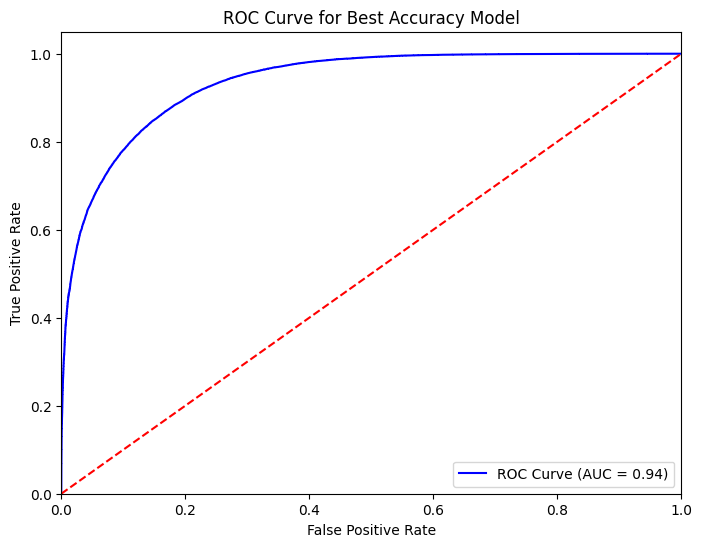

Best Accuracy Trial: 17
Best Accuracy: 0.8532


In [13]:
from sklearn.metrics import roc_curve, auc

# Find the trial with the best accuracy
best_accuracy_trial = results_df.loc[results_df['Accuracy'].idxmax()]
best_trial_number = best_accuracy_trial['trial']

# Refit the MLP model with the hyperparameters of the best accuracy trial
mlp_best_accuracy = MLPClassifier(
    hidden_layer_sizes=best_accuracy_trial['hidden_layer_sizes'],
    activation=best_accuracy_trial['activation'],
    solver=best_accuracy_trial['solver'],
    alpha=best_accuracy_trial['alpha'],
    learning_rate_init=best_accuracy_trial['learning_rate_init'],
    max_iter=300,
    early_stopping=True
)

# Train the model on the training set
mlp_best_accuracy.fit(X_train_opt, y_train_opt)

# Predict probabilities on the validation set for ROC curve
y_valid_proba_best_accuracy = mlp_best_accuracy.predict_proba(X_valid_opt)[:, 1]

# Generate ROC curve data
fpr, tpr, thresholds = roc_curve(y_valid_opt, y_valid_proba_best_accuracy)
roc_auc = auc(fpr, tpr)

# Plot ROC curve for the model with the best accuracy
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Best Accuracy Model')
plt.legend(loc="lower right")
plt.show()

print(f'Best Accuracy Trial: {best_trial_number}')
print(f'Best Accuracy: {best_accuracy_trial["Accuracy"]:.4f}')


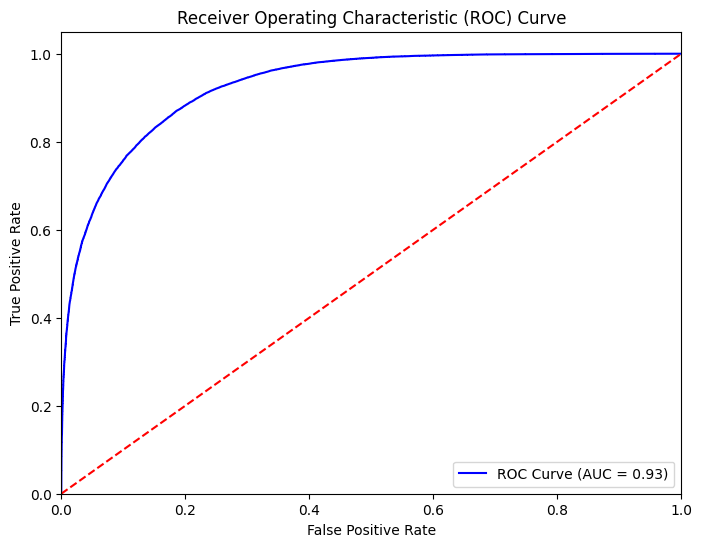

In [17]:
# Refit the MLP model with the best hyperparameters on the full training data
mlp_best = MLPClassifier(
    hidden_layer_sizes=best_params_mlp['hidden_layer_sizes'],
    activation=best_params_mlp['activation'],
    solver=best_params_mlp['solver'],
    alpha=best_params_mlp['alpha'],
    learning_rate_init=best_params_mlp['learning_rate_init'],
    max_iter=300,
    early_stopping=True
)

# Train the model on the full training data (train and validation combined)
mlp_best.fit(X_train_flat, y_train_flat)

# Predict probabilities on the test data
y_test_proba = mlp_best.predict_proba(X_test_flat)[:, 1]

# Generate ROC curve data
fpr, tpr, thresholds = roc_curve(y_test_flat, y_test_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for MLP hypertuned)
plt.legend(loc="lower right")
plt.show()


In [14]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Predict classes on the test data
y_test_pred = mlp_best.predict(X_test_flat)

# Calculate Precision, Recall, and F1 score
precision = precision_score(y_test_flat, y_test_pred)
recall = recall_score(y_test_flat, y_test_pred)
f1 = f1_score(y_test_flat, y_test_pred)

# Print the Precision, Recall, and F1 score
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')


# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve for MLP hypertuned")
plt.legend(loc="lower right")
plt.show()


NameError: name 'mlp_best' is not defined

In [ ]:
import plotly
optuna.visualization.plot_optimization_history(study_mlp)
plt.show()

# Plot the parallel coordinate plot for hyperparameters
optuna.visualization.plot_parallel_coordinate(study_mlp)
plt.show()


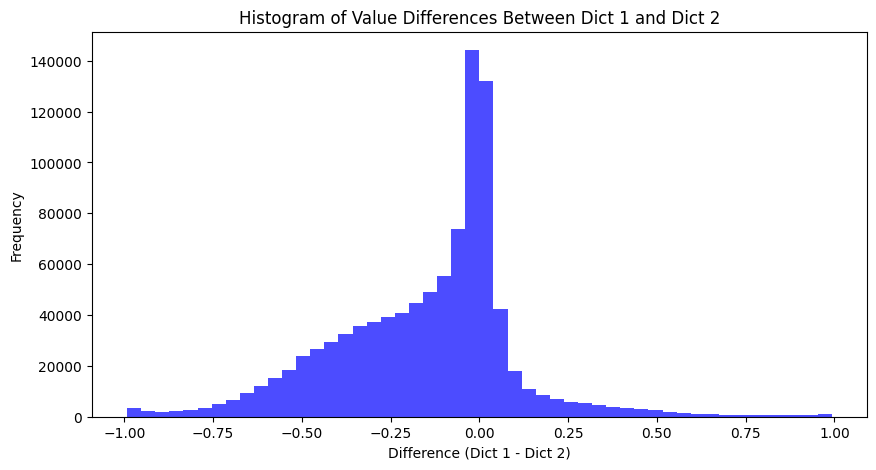

In [13]:
import matplotlib.pyplot as plt

# Find common keys
common_keys = list(set(avg_mod_qual_a.keys()).intersection(avg_mod_qual_b.keys()))

# Calculate the differences between the values
differences = [avg_mod_qual_a[key] - avg_mod_qual_b[key] for key in common_keys]

# Plot histogram of differences
plt.figure(figsize=(10, 5))
plt.hist(differences, bins=50, alpha=0.7, color='blue')
plt.xlabel('Difference (Dict 1 - Dict 2)')
plt.ylabel('Frequency')
plt.title('Histogram of Value Differences Between Dict 1 and Dict 2')
plt.show()


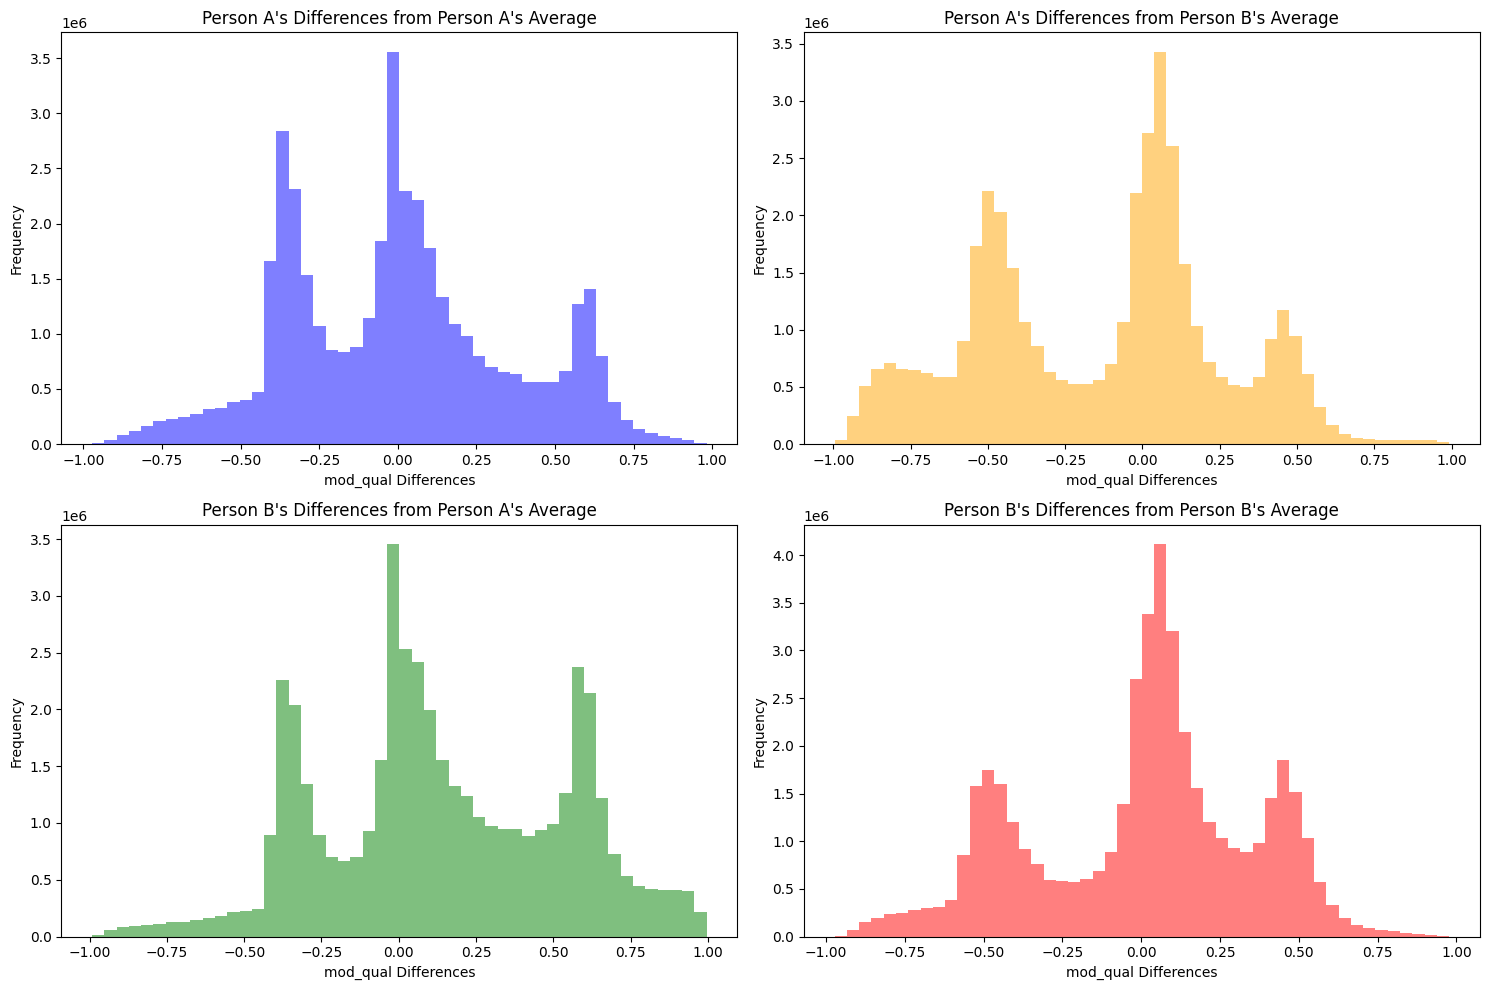

In [6]:
import matplotlib.pyplot as plt
import torch

# Step 1: Calculate the average mod_qual for each CpG in train1 and train2
def calculate_avg_mod_qual(df):
    return df.groupby('CpG_site')['mod_qual'].mean().to_dict()

avg_mod_qual_a = calculate_avg_mod_qual(train1)  # Person A averages
avg_mod_qual_b = calculate_avg_mod_qual(train2)  # Person B averages

# Step 2: Calculate the differences directly from train1 and train2
def calculate_differences(df, avg_mod_qual_a, avg_mod_qual_b):
    diff_a_from_a = []
    diff_b_from_a = []
    diff_a_from_b = []
    diff_b_from_b = []
    
    for _, row in df.iterrows():
        cpg = row['CpG_site']
        mod_qual = row['mod_qual']
        
        # For CpG sites where we have an average for both Person A and Person B
        if cpg in avg_mod_qual_a and cpg in avg_mod_qual_b:
            # Difference from Person A's average
            diff_a = mod_qual - avg_mod_qual_a[cpg]
            # Difference from Person B's average
            diff_b = mod_qual - avg_mod_qual_b[cpg]
            
            if row['person'] == 'A':  # If current row is from Person A
                diff_a_from_a.append(diff_a)
                diff_b_from_a.append(diff_b)
            elif row['person'] == 'B':  # If current row is from Person B
                diff_a_from_b.append(diff_a)
                diff_b_from_b.append(diff_b)
    
    return diff_a_from_a, diff_b_from_a, diff_a_from_b, diff_b_from_b

# Add a 'person' column to distinguish between train1 and train2
train1['person'] = 'A'
train2['person'] = 'B'

# Combine train1 and train2 for easier processing
combined_train = pd.concat([train1, train2])

# Get the differences for both persons
diff_a_from_a, diff_b_from_a, diff_a_from_b, diff_b_from_b = calculate_differences(combined_train, avg_mod_qual_a, avg_mod_qual_b)

# Step 3: Plot the differences in 4 plots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# 1. Person A's differences from Person A's average
axs[0, 0].hist(diff_a_from_a, bins=50, alpha=0.5, color='blue')
axs[0, 0].set_title("Person A's Differences from Person A's Average")
axs[0, 0].set_xlabel('mod_qual Differences')
axs[0, 0].set_ylabel('Frequency')

# 2. Person A's differences from Person B's average
axs[0, 1].hist(diff_b_from_a, bins=50, alpha=0.5, color='orange')
axs[0, 1].set_title("Person A's Differences from Person B's Average")
axs[0, 1].set_xlabel('mod_qual Differences')
axs[0, 1].set_ylabel('Frequency')

# 3. Person B's differences from Person A's average
axs[1, 0].hist(diff_a_from_b, bins=50, alpha=0.5, color='green')
axs[1, 0].set_title("Person B's Differences from Person A's Average")
axs[1, 0].set_xlabel('mod_qual Differences')
axs[1, 0].set_ylabel('Frequency')

# 4. Person B's differences from Person B's average
axs[1, 1].hist(diff_b_from_b, bins=50, alpha=0.5, color='red')
axs[1, 1].set_title("Person B's Differences from Person B's Average")
axs[1, 1].set_xlabel('mod_qual Differences')
axs[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()
